In [28]:
import os,json
import alphashape
import subprocess
import rasterio
from rasterio.plot import show
from rasterio.windows import Window
import earthpy.plot as ep
import earthpy.spatial as es
import numpy as np
import floodtools as ft
from floodtools import Cell
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps, colors
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize, CenteredNorm, SymLogNorm, LogNorm
from collections import Counter, defaultdict, deque
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.polygon import Polygon as sPolygon
plt.close("all")

## Load DEM Files

In [2]:
files = [os.path.join("dem",file) for file in os.listdir("dem") if file.split(".")[-1] == "tif"]
upper_left = files[2] 
upper_right = files[3]
lower_left = files[0]
lower_right = files[1]
files = {"upper_left":upper_left,"upper_right":upper_right,
         "lower_left":lower_left,"lower_right":lower_right}

crop_boundaries = {"upper_left":{"minx":124.84466,"miny":8.00000,"maxx":125.00000,"maxy":8.06225},
                   "upper_right":{"minx":125.00000,"miny":8.00000,"maxx":125.29264,"maxy":8.06225},
                   "lower_left":{"minx":124.84466,"miny":7.77149,"maxx":125.00000,"maxy":8.00000},
                   "lower_right":{"minx":125.00000,"miny":7.77149,"maxx":125.29264,"maxy":8.00000}}
for i,(key,val) in enumerate(files.items()):
    print(f"{i+1}. {key} -- {val}")

1. upper_left -- dem\n08_e124_1arc_v3.tif
2. upper_right -- dem\n08_e125_1arc_v3.tif
3. lower_left -- dem\n07_e124_1arc_v3.tif
4. lower_right -- dem\n07_e125_1arc_v3.tif


## Crop the DEM files

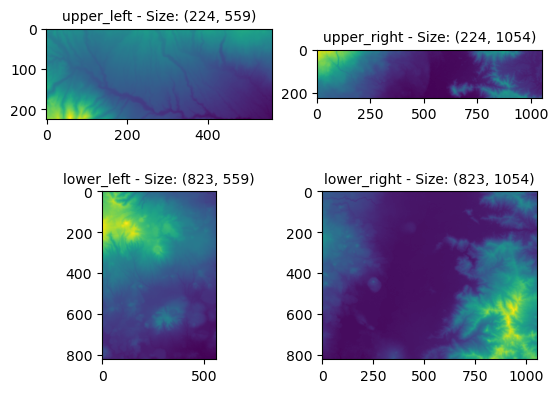

In [3]:
cropped_dir = "dem_cropped"
if not os.path.exists(cropped_dir):
    os.makedirs(cropped_dir)

fig,axes = plt.subplots(nrows= 2, ncols = 2)
axes = axes.ravel()

cropped_data = {}
for i,(loc,filename) in enumerate(files.items()):
    with rasterio.open(filename) as dem:
        #get the geographic boundaries
        left = crop_boundaries[loc]["minx"]
        bottom = crop_boundaries[loc]["miny"]
        right = crop_boundaries[loc]["maxx"]
        top = crop_boundaries[loc]["maxy"]
        
        #upper left
        ulx, uly = left,top
        
        #lower right
        lrx, lry = right, bottom
        
        #upper left indices
        urow,ucol = dem.index(ulx,uly)
        
        #lower right indices
        lrow, lcol = dem.index(lrx,lry)
        
        #number increases downward and rightward
        height = lrow - urow
        width =  lcol - ucol
        
        #setup window to crop
        window = Window(ucol,urow,width,height)
        cropped = dem.read(window = window)
        
        #update metadata for cropped data
        transform = rasterio.windows.transform(window,dem.transform)
        profile = dem.profile
        profile.update(transform=transform, height = height,  width = width)
        outputfile = os.path.join(cropped_dir,f"{loc}.tif")
        
        with rasterio.open(outputfile,"w",**profile) as outfile:
            outfile.write(cropped)
        
        ax = axes[i]
        cropped = np.squeeze(cropped)
        cropped_data[loc] = cropped
        ax.imshow(cropped)
        ax.set_title(f"{loc} - Size: {cropped.shape}",fontsize = 10)

## Merge the Cropped DEM files

After area of interest is determined, the cropped DEM files will be merged into a single raster file.

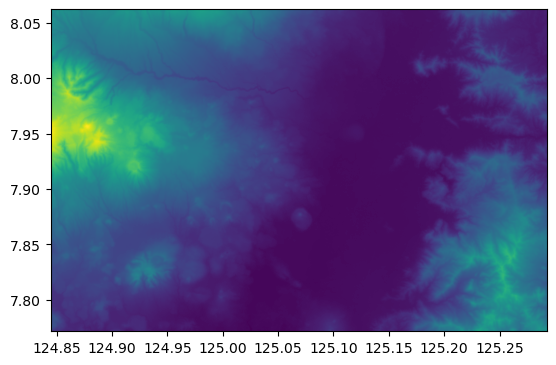

In [4]:
cropped_files = [os.path.join(cropped_dir,file) for file in files.keys()]


upper = np.hstack((cropped_data["upper_left"],cropped_data["upper_right"]))
lower = np.hstack((cropped_data["lower_left"],cropped_data["lower_right"]))
merged = np.vstack((upper,lower))

merged_dir = "dem_merged"
if not os.path.exists(merged_dir):
    os.makedirs(merged_dir)


west = crop_boundaries["lower_left"]["minx"]
south = crop_boundaries["lower_left"]["miny"]
east = crop_boundaries["upper_right"]["maxx"]
north = crop_boundaries["upper_right"]["maxy"]
width,height = int(merged.shape[1]), int(merged.shape[0])

transform = rasterio.transform.from_bounds(west, south, east, north, width, height)
profile.update(width = merged.shape[1], height = merged.shape[0],transform = transform)

merged_file = os.path.join(merged_dir,"merged.tif")
with rasterio.open(merged_file,"w",**profile) as mergedfile:
    mergedfile.write(merged[np.newaxis,:,:])
       

plt.figure() 
with rasterio.open(merged_file) as dem:
    show(dem)
    

## Sink Filling
The script accepts a **.npy** file containing the Digital Elvation Model (DEM) from **numpy** array of data type **np.float64**. The output is the resulting sink-filled DEM using the modified Planchon-Darboux Algorithm by [Wei, Zhou, & Dong](https://www.mdpi.com/2220-9964/8/4/164) (2019).

The parameter **epsilon** ($\varepsilon$) controls the minium vertical gradient between nearby cells. This can be adjusted ($\varepsilon > 0$) so that the resulting sink-filled DEM can have have a slightly sloping profile aiding the flow accumulation methods by preventing perfectly flat areas.

The algorithm uses a similar priority queue and regular queue approach as the original [Planchon and Darboux Algorithm](https://www.sciencedirect.com/science/article/abs/pii/S0341816201001643) (2001).


In [5]:
#read the merged_file .tif file
with rasterio.open(merged_file) as file:
    dem = np.squeeze(file.read()).astype(np.float64) #important
    dem = np.flip(dem,axis = 0)

sink_filling_dir = "sink_filling"
dem_input_npy = os.path.join(sink_filling_dir,"dem.npy")
dem_output_npy = os.path.join(sink_filling_dir,"filled.npy")

#write the merged dem as a .npy object
with open(dem_input_npy,"wb") as file:
    np.save(file,dem)
    
epsilon = 0.001
executable = os.path.join(sink_filling_dir,"planchon_darboux.exe")
args = [dem_input_npy,str(epsilon),dem_output_npy]

try:
    result = subprocess.run([executable] + args,
                            stdout = subprocess.PIPE,
                            stderr = subprocess.PIPE,
                            text = True)
    if result.returncode == 0:
        #print(result.stdout)
        print(f"Sink nodes filled with epsilon = {epsilon}")
    else:
        print(result.stderr)
        
except FileNotFoundError:
    print("Executable not found.")
    
dem_resolution = 30
dem = np.flip(np.load(dem_input_npy),axis = 0)
filled = np.flip(np.load(dem_output_npy),axis = 0)

filled_tif = os.path.join(merged_dir,"filled.tif")
#save filled dem as a .tif file
with rasterio.open(filled_tif,"w",**profile) as filled_file:
    filled_file.write(filled[np.newaxis,:,:].astype(np.float32))


Sink nodes filled with epsilon = 0.001


## Iterative Sink-Filling Method
By Pelletier (2008)

In [6]:
#merged_file = os.path.join("dem_merged","merged.tif")
#with rasterio.open(merged_file) as file:
#    original = np.squeeze(file.read())
#    original = np.flip(original,axis = 0).astype(np.float64)
#    rows,cols = original.shape
#dem = original.copy()

"""
epsilon = 0.9
offsets = [(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1)]
def fill(dem,i,j,offsets,depth = 0,max_depth = 300):
    if depth > max_depth:
        return
    
    minimum = dem[i,j]
    for rowoff,coloff in offsets:
        nextrow = i + rowoff
        nextcol = j + coloff
        if 0 <= nextrow < rows and 0 <= nextcol < cols:
            value = dem[nextrow,nextcol]
            if value < minimum:
                minimum = value
    if dem[i,j] <= minimum:
        dem[i,j] = minimum + epsilon
        depth  = depth + 1
        for roff,coloff in offsets:
            nextrow = i + roff
            nextcol = j + coloff
            if 0 <= nextrow < rows and 0 <= nextcol < cols:
                fill(dem,nextrow,nextcol,offsets, depth = depth ,max_depth = max_depth)
    

sort_indices = []
for i in range(rows):
    for j in range(cols):
        value = dem[i,j]
        sort_indices.append((i,j,value))
sort_indices = sorted(sort_indices,key = lambda item: item[-1])
         
filled = dem.copy()
for n,(i,j, _) in enumerate(sort_indices):
    fill(filled,i,j, offsets,depth = 0, max_depth = 1000)
    if n % 10000 == 0:
        print(f"Iteration {n} of {rows*cols}")
        
filled_tif = os.path.join(merged_dir,"filled.tif")
#save filled dem as a .tif file
with rasterio.open(filled_tif,"w",**profile) as filled_file:
    filled_file.write(filled[np.newaxis,:,:].astype(np.float32))"""
        

'\nepsilon = 0.9\noffsets = [(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1)]\ndef fill(dem,i,j,offsets,depth = 0,max_depth = 300):\n    if depth > max_depth:\n        return\n    \n    minimum = dem[i,j]\n    for rowoff,coloff in offsets:\n        nextrow = i + rowoff\n        nextcol = j + coloff\n        if 0 <= nextrow < rows and 0 <= nextcol < cols:\n            value = dem[nextrow,nextcol]\n            if value < minimum:\n                minimum = value\n    if dem[i,j] <= minimum:\n        dem[i,j] = minimum + epsilon\n        depth  = depth + 1\n        for roff,coloff in offsets:\n            nextrow = i + roff\n            nextcol = j + coloff\n            if 0 <= nextrow < rows and 0 <= nextcol < cols:\n                fill(dem,nextrow,nextcol,offsets, depth = depth ,max_depth = max_depth)\n    \n\nsort_indices = []\nfor i in range(rows):\n    for j in range(cols):\n        value = dem[i,j]\n        sort_indices.append((i,j,value))\nsort_indices = sorted(sort_indices,

### Results from Sink-Filling
Highlighted areas represents the difference between the original and the sink-filled regions. The lighter the color, the larger the difference.

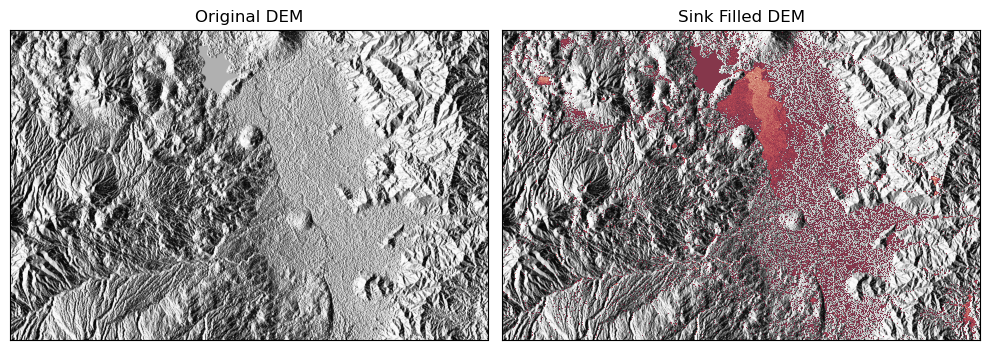

In [7]:
fig = plt.figure(figsize = (10,4))
#light source azimuth and altitude angle
az,alt = 270,10


hillshade = es.hillshade(np.flip(dem,axis = 0),azimuth = az,altitude=alt)
ax = fig.add_subplot(121)
ep.plot_bands(hillshade,cbar = False,ax = ax)
ax.set_title("Original DEM")

hillshade = es.hillshade(np.flip(filled,axis = 0),azimuth = az,altitude=alt)
ax = fig.add_subplot(122)
ep.plot_bands(hillshade,cbar = False,ax = ax)
ax.set_title("Sink Filled DEM")

diff = filled-dem
diff[diff == 0] = np.nan

xs,ys = np.meshgrid(range(dem.shape[1]), range(dem.shape[0]))
img = ax.pcolormesh(xs,ys,np.flip(diff,axis=0),alpha = 0.7,cmap = "RdBu")
plt.tight_layout()
plt.show()


### Needed Constants

In [8]:
#SRTM data resolution is 30m by 30m
dem_resolution = 30

#Discrete convolution kernels needed for some operations
L8 = (1/(3*dem_resolution**2)) * np.array([[1,1,1],[1,-8,1],[1,1,1]])
sobel_xkernel = np.array([[-1,0,1],
                    [-2,0,2],
                    [-1,0,1]])
sobel_ykernel = np.array([[1,2,1],
                    [0,0,0],
                    [-1,-2,-1]])
sobel_scale = 1/(8*dem_resolution)

## Solving for the Natural Morphological Characteristics
These are properties of the terrain prior to sink-filling

In [9]:
dem = np.flip(dem,axis = 0)

dzdx = sobel_scale*ft.conv(dem,sobel_xkernel)
dzdy = sobel_scale*ft.conv(dem,sobel_ykernel)
slope = np.sqrt(dzdx**2 + dzdy**2)
angle = np.arctan(slope)*180/np.pi
print("Slope calculated.")

curvature = ft.conv(dem,L8)
print("Curvature calculated.")

aspect = np.arctan2(dzdy, dzdx)
aspect = np.degrees(aspect)
aspect = (aspect - 90) % 360
aspect[np.where(slope == 0)] = np.nan
print("Aspect calculated.")


Slope calculated.
Curvature calculated.
Aspect calculated.


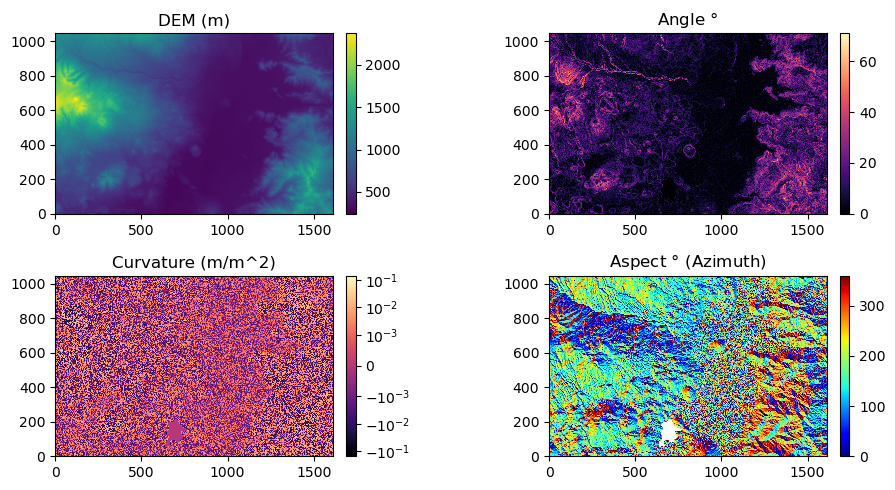

Basic morphological properties calculated.


In [10]:
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(221)
img = ax.pcolormesh(xs,ys,dem)
ax.set_aspect(1)
ax.set_title("DEM (m)")
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)

ax = fig.add_subplot(222)
img = ax.pcolormesh(xs,ys,angle,cmap = "magma")
ax.set_aspect(1)
ax.set_title("Angle " + r"$\degree$")
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)

ax = fig.add_subplot(223)
img = ax.pcolormesh(xs,ys,curvature,cmap = "magma",norm = SymLogNorm(linthresh = 0.001))
ax.set_aspect(1)
ax.set_title("Curvature (m/m^2)")
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)

ax = fig.add_subplot(224)
img = ax.pcolormesh(xs,ys,aspect,cmap="jet")
ax.set_aspect(1)
ax.set_title("Aspect "+r"$\degree$"+" (Azimuth)")
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)

plt.tight_layout()
plt.show()

print("Basic morphological properties calculated.")

### Histograms

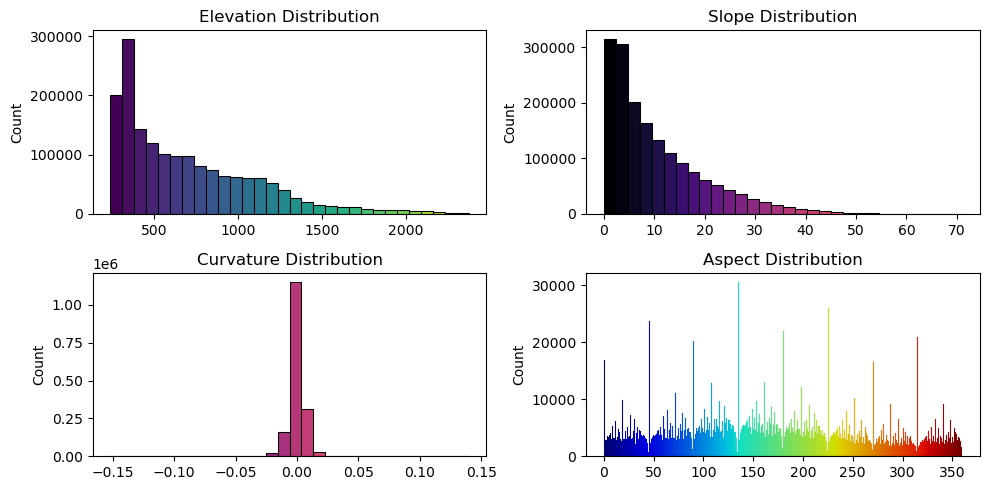

In [11]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(221)
cmap = plt.colormaps.get_cmap('viridis')
norm = plt.Normalize(vmin=merged.min(), vmax=merged.max())
hist = sns.histplot(merged.ravel(), bins=30)
for i, rect in enumerate(hist.patches):
    boundary = rect.get_x()
    color = cmap(norm(boundary))
    rect.set_facecolor(color)
plt.title("Elevation Distribution")
#cbar = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
#ax.figure.colorbar(cbar)

ax = fig.add_subplot(222)
cmap = plt.colormaps.get_cmap('magma')
norm = plt.Normalize(vmin=angle.min(), vmax=angle.max())
hist = sns.histplot(angle.ravel(), bins=30)
for i, rect in enumerate(hist.patches):
    boundary = rect.get_x()
    color = cmap(norm(boundary))
    rect.set_facecolor(color)
plt.title("Slope Distribution")

ax = fig.add_subplot(223)
cmap = plt.colormaps.get_cmap('magma')
norm = plt.Normalize(vmin=curvature.min(), vmax=curvature.max())
hist = sns.histplot(curvature.ravel(), bins=30)
for i, rect in enumerate(hist.patches):
    boundary = rect.get_x()
    color = cmap(norm(boundary))
    rect.set_facecolor(color)
plt.title("Curvature Distribution")

ax = fig.add_subplot(224)
cmap = plt.colormaps.get_cmap('jet')
norm = plt.Normalize(vmin=0, vmax=360)
hist = sns.histplot(aspect.ravel(), bins=360)
for i, rect in enumerate(hist.patches):
    boundary = rect.get_x()
    color = cmap(norm(boundary))
    rect.set_facecolor(color)
plt.title("Aspect Distribution")

plt.tight_layout()
plt.show()

## Flow Accumulation

In [12]:
#keep a copy of the original dem
dem_unfilled = dem.copy()

#Replace the DEM with the filled DEM
dem = np.flip(filled,axis = 0)

dzdx = sobel_scale*ft.conv(dem,sobel_xkernel)
dzdy = sobel_scale*ft.conv(dem,sobel_ykernel)
slope = np.sqrt(dzdx**2 + dzdy**2)
angle = np.arctan(slope)*180/np.pi
print("Slope calculated.")

curvature = ft.conv(dem,L8)
print("Curvature calculated.")

aspect = np.arctan2(dzdy, dzdx)
aspect = np.degrees(aspect)
aspect = (aspect - 90) % 360
aspect[np.where(slope == 0)] = np.nan
print("Aspect calculated.")

Slope calculated.
Curvature calculated.
Aspect calculated.


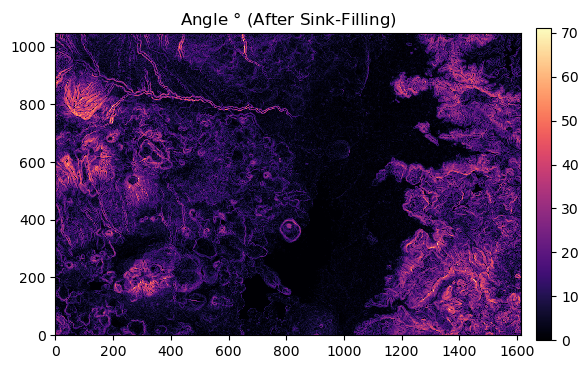

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
img = ax.pcolormesh(xs,ys,angle,cmap = "magma")
ax.set_aspect(1)
ax.set_title("Angle " + r"$\degree$" + " (After Sink-Filling)")
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)

In [14]:
#create cell objects
CELLS = []
CELL_SORT = []
rows,cols = dem.shape
for i in range(rows):
    cellrow = []
    for j in range(cols):
        angle = aspect[i,j]
        elevation = dem[i,j]
        cell = Cell(i,j,angle,elevation) #keep in mind that j is col or x
        cellrow.append(cell)
        CELL_SORT.append(cell)
    CELLS.append(cellrow)
CELL_SORT = sorted(CELL_SORT,key = lambda cell: cell.elevation,reverse = True)
print("Cell objects created.")

Cell objects created.


In [15]:
flow_accum_method = "mfd"

for row in range(rows):
    for col in range(cols):
        cell = CELLS[row][col]
        theta  = cell.aspect
        
        #get candidate neighbors
        candidate_angles,candidate_offsets = ft.get_neighbors(theta,method = flow_accum_method)
        qualified_angles, qualified_neighbors = [], []
        
        #coloff is the x offset, rowoff is the y offset (relative to the raster coordinate)
        for angle,(coloff,rowoff) in zip(candidate_angles,candidate_offsets):
            new_row = row + rowoff
            new_col = col + coloff
                        
            if (0 <= new_row < rows) and (0 <= new_col < cols):
                neighbor = CELLS[new_row][new_col]
                if neighbor.elevation <= cell.elevation:
                    qualified_neighbors.append(neighbor)
                    qualified_angles.append(angle)
        cell.neighbors = qualified_neighbors
        cell.neighbor_angles = qualified_angles
        if len(qualified_neighbors) == 0:
            cell.is_sink = True
                
print("Cell neighbors identified")           


Cell neighbors identified


In [16]:
#get neighbor proportions
for i in range(rows):
    for j in range(cols):
        cell = CELLS[i][j]
        proportions = ft.get_flow_proportion(cell,method = flow_accum_method,p = 1.1,dem_resolution = 30)
        
        if not cell.is_sink:
            #Checking: Non-sink cells must not have empty flow
            for p in proportions:
                if np.isnan(p):
                    raise Exception(f"Empty proportions at:\n{cell}")
        cell.neighbor_proportions = proportions
print("Neighbor proportions calculated.")

for cell in CELL_SORT:
    if not cell.is_sink:
        cell.flowall()
print("Flow accumulation done.")

Neighbor proportions calculated.
Flow accumulation done.


Text(0.5, 1.0, 'Accumulation Distribution')

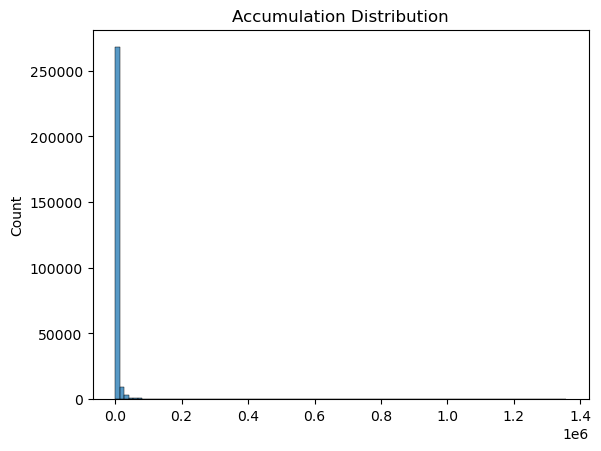

In [17]:
accumulations = np.zeros_like(dem).astype(float)
for cell in CELL_SORT:
    accumulations[cell.row,cell.col] = cell.accum
    
fig = plt.figure()
ax = fig.add_subplot(111)
cmap = plt.colormaps.get_cmap('magma')
norm = plt.Normalize(vmin=accumulations.min(), vmax=accumulations.max())
hist = sns.histplot(accumulations[accumulations > 50].ravel(),bins = 100)
#for i, rect in enumerate(hist.patches):
#    boundary = rect.get_x()
#    color = cmap(norm(boundary))
#    rect.set_facecolor(color)
plt.title("Accumulation Distribution")

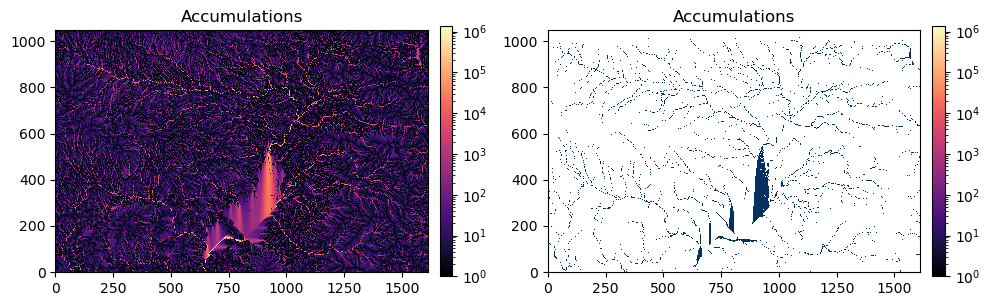

In [18]:
def mask(mat,limit,low = 0,high = 1):
    data = mat.copy()
    data[data < limit] = low
    data[data >= limit] = high
    return data

river = mask(accumulations,1000,low = np.nan)
      
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(121)
img = ax.pcolormesh(xs,ys,accumulations,cmap = "magma",norm = LogNorm())
ax.set_aspect(1)
ax.set_title("Accumulations")
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)

ax = fig.add_subplot(122)
#img = ax.pcolormesh(xs,ys,dem)

#hillshade = es.hillshade(filled,azimuth = az,altitude=alt)
#ep.plot_bands(hillshade,cbar = False,ax = ax)

ax.pcolormesh(xs,ys,river,cmap = "RdBu_r")
ax.set_aspect(1)
ax.set_title("Accumulations")
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)


skip = 50
if False:
    ax = fig.add_subplot(122)
    img = ax.pcolormesh(xs,ys,dem,cmap="viridis")
    for i in range(0,aspect.shape[0],skip):
        for j in range(0,aspect.shape[1],skip):
            theta = aspect[i,j]
            
            #not reversed since aspect starts from north
            dy = np.cos(np.radians(theta))
            dx = np.sin(np.radians(theta))
            x = j - 0.5*dx
            y = i - 0.5*dy
            plt.arrow(x,y,dx,dy,color ="red",head_width = 0.2,head_length = 0.5)
        

    ax.set_xlim([0,dem.shape[1]])
    ax.set_ylim([0,dem.shape[0]])
    ax.set_aspect(1)
    ax.set_title("Accumulations")
    fig.colorbar(img,ax = ax, orientation = "vertical")
    
plt.tight_layout()

In [19]:
CELL_SORT = []
for row in CELLS:
    for cell in row:
        if cell.accum > 0:
            CELL_SORT.append(cell)

CELL_SORT = sorted(CELL_SORT,key = lambda cell: cell.accum,reverse = True)


In [20]:
# reset search-affected variables (only needed when redoing search without running from the top)
for row in range(rows):
    for col in range(cols):
        CELLS[row][col].is_explored = False
        CELLS[row][col].path_id = None



# start with the cell with the highest accumulation
# search for all cells connected to it and assign the current path id
# if the search has exhausted all the cells connected
# the search starts with the next unexplored cell with the
# highest accumulation value
print("Catchment search started.")
path = 0
for cell in CELL_SORT:
    if not cell.is_explored:
        ft.search(cell,path,method = "bfs")
        path += 1
print("Catchments identified.")
       
#count the number of cells for a certain path id
path_ids = []
for cell in CELL_SORT:
    path_ids.append(cell.path_id)
id_counts = Counter(path_ids)


Catchment search started.
Catchments identified.


In [22]:
# filter the path ids using the the number of cells per path
# as compared to the min_catchment_size
min_catchment_size = 1000
qualified_paths = {key for key,val in id_counts.items() if val >= min_catchment_size}
groups = np.empty_like(dem).astype(float)
#groups[groups == 0] = np.nan


name = 1
path_names = {}
for cell in CELL_SORT:
    if cell.path_id in qualified_paths:
        if cell.path_id in path_names:
            groups[cell.row,cell.col] = path_names[cell.path_id]
        else:
            groups[cell.row,cell.col] = name
            path_names[cell.path_id] = name
            name += 1

#susbtract one since the last addition prepares for the next
print(f"Catchments filtered ({name-1}).")

Catchments filtered (29).


In [23]:
CELL_UNSORTED = set(CELL_SORT)
CELLS_PER_PATH_NAME = {}
DEEPEST_CELL_PER_PATH_NAME = {}
BORDER_CELLS_PER_PATH_NAME = {}

offsets = [(-1,0),(0,1),(1,0),(0,-1)]
borders = np.empty_like(dem).astype(float)
for path in qualified_paths:
    cells_in_path = set(filter(lambda cell:cell.path_id == path,CELL_UNSORTED))
    deepest_cell = min(cells_in_path,key = lambda cell: cell.elevation)
    CELLS_PER_PATH_NAME[path_names[path]] = cells_in_path
    DEEPEST_CELL_PER_PATH_NAME[path_names[path]] = deepest_cell
    
    border_cells = []
    for cell in cells_in_path:
        is_border = False
        for rowoff,coloff in offsets:
            nextrow = cell.row + rowoff
            nextcol = cell.col + coloff
            if (0 <= nextrow < rows) and (0 <= nextcol < cols):
                neighbor = CELLS[nextrow][nextcol]
                if neighbor.path_id != cell.path_id:
                    is_border = True
                    break
            else:
                # comment this out if you don't want to treat the dem
                # border as a catchment border
                #is_border = True
                break
                
        if is_border:
            borders[cell.row,cell.col] = path
            border_cells.append(cell)
        else:
            borders[cell.row,cell.col] = np.nan
    BORDER_CELLS_PER_PATH_NAME[path_names[path]] = border_cells

                
    
border_rows,border_cols = np.where(~np.isnan(borders))

# to be used as border colors
# according to the path name (not path id)
# remember that not all path ids are name
# due to the threshold
border_path_ids = []
for row,col in zip(border_rows,border_cols):

    color = path_names[borders[row,col]]

    border_path_ids.append(color)



In [24]:
#for each border cell get the corresponding path name
border_rows,border_cols = np.where(~np.isnan(borders))
border_path_names = []
for row,col in zip(border_rows,border_cols):
    name = path_names[borders[row,col]]
    border_path_names.append(name)

    
# get the ordered border paths per catchment
# organize with path names as keys
# order is counter clockwise
ordered_border_vertices = {}

for path_name in path_names.values():
    border_cells_in_path = BORDER_CELLS_PER_PATH_NAME[path_name]
    vertices = np.array([[cell.col,cell.row] for cell in border_cells_in_path])
    ordered_border_vertices[path_name] = ft.order_vertices(vertices)
    

In [25]:
# get centroids of each region to place texts
centroids = {}
for path in qualified_paths:
    cells_in_path = set(filter(lambda cell:cell.path_id == path,CELL_UNSORTED))
    area = id_counts[path]
    row_coords = [cell.row for cell in cells_in_path]
    col_coords = [cell.col for cell in cells_in_path]
    crow,ccol = np.mean(row_coords),np.mean(col_coords)
    centroids[path_names[path]] = (crow,ccol,area)
centroids

{1: (560.1415403875634, 801.4968121308245, 1394662),
 2: (237.51529665411277, 80.36490912068119, 73284),
 3: (941.2385562328194, 1510.9290068124776, 41835),
 4: (101.35915806116903, 385.91405207767184, 40478),
 5: (77.69740338164252, 231.02445652173913, 16560),
 6: (686.6425246195165, 1558.8516562220232, 11170),
 7: (168.104572175049, 1535.8786414108426, 15310),
 8: (500.80276515517744, 1547.631538238422, 10343),
 9: (56.68262126566013, 1502.27411928472, 9339),
 10: (420.71235498146154, 1569.6800621935174, 8361),
 11: (76.0246339762956, 1573.4389960492679, 4303),
 12: (248.7256567252617, 1562.8913687537033, 5063),
 13: (787.7287552092771, 1567.22558434499, 5519),
 14: (329.16971654108363, 1570.6636167922497, 5574),
 15: (24.514980353634577, 1150.6819744597249, 4072),
 16: (306.04471879286695, 13.835390946502057, 3645),
 17: (724.7328748280605, 22.78349381017882, 3635),
 18: (20.580346355215465, 771.3383004430125, 2483),
 19: (270.0061728395062, 1592.6206509539843, 1782),
 20: (19.25804

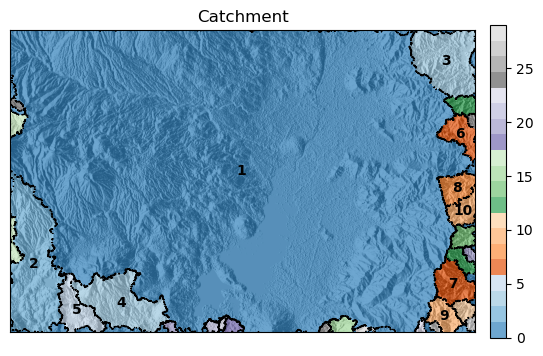

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

hillshade = es.hillshade(np.flip(filled,axis = 0),azimuth = az,altitude=alt)
ep.plot_bands(hillshade,cbar = False,ax = ax)

img = ax.pcolormesh(xs,ys,groups,cmap = "tab20c",alpha = 0.7)
#ax.scatter(border_cols,border_rows,s = 1,c = "black",marker = "v")
from matplotlib.patches import Polygon


  
for _,path_name in path_names.items():
    cells_in_path = BORDER_CELLS_PER_PATH_NAME[path_name]
    vertices = np.array([[cell.col,cell.row] for cell in cells_in_path])
    shape = alphashape.alphashape(vertices,alpha = 0.5)
    #polygon = Polygon(np.array(shape.exterior.coords),edgecolor = "k",fill = False)
    #ax.add_patch(polygon)
    
    if isinstance(shape,MultiPolygon):
        for i,polygon in enumerate(shape.geoms):
            coords = np.array(polygon.exterior.coords)
            #ax.plot(coords[:, 0], coords[:, 1], c='red')
            border_patch = Polygon(coords,edgecolor = "k",facecolor = "k", fill = True)
            ax.add_patch(border_patch)
    elif isinstance(shape,sPolygon):
        #ax.plot(*shape.exterior.xy, c='red', alpha=0.7)
        coords = shape.exterior.xy
        border_patch = Polygon(np.c_[coords],edgecolor = "k",facecolor = "k",fill = True)
        ax.add_patch(border_patch)
    


ax.invert_yaxis()
ax.set_aspect(1)
ax.set_title("Catchment")
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)

#only display texts larger than the threshold to prevent crowding
text_display_threshold = 6000
for path,(crow,ccol,area) in centroids.items():
    if area >= text_display_threshold:
        ax.text(ccol,crow,path,ha = "center", va = "center",fontweight = "bold")

## Export Network Data
To be used for HAND calculations

In [29]:
def id_hash(row,col,rows,cols):
    return row*cols + col%cols

def reverse_hash(cell_id,cols):
    row = cell_id//cols
    col = cell_id - row*cols
    return row,col

cells_json = {}
for row in CELLS:
    for cell in row:
        data = {"row":cell.row,"col":cell.col,"accum":cell.accum,"elev":cell.elevation}
        neighbors = []
        #parents = []
        for neighbor in cell.neighbors:
            neighbors.append([neighbor.row,neighbor.col])
            
        #for parent in cell.parents:
        #    parents.append([parent.row,parent.col])
            
        data["neighbors"] = neighbors
        #data["parents"] = parents
        
        cell_id = id_hash(cell.row,cell.col,rows,cols)
        cells_json[cell_id] = data


accum_dir = "accumulations"
if not os.path.exists(accum_dir):
    os.makedirs(accum_dir)

with open(os.path.join(accum_dir,"cells.json"),"w") as json_file:
    json.dump(cells_json,json_file)

print("Network json data written.")

Network json data written.


## Calculating HAND Values

In [51]:
hand_calculation_dir = "./hand_calculation"

input_file = "./accumulations/cells.json"
args = ["hand_calculation/hand_calculate",
        "--input-file",input_file,
        "--rows",dem.shape[0],
        "--cols",dem.shape[1],
        "--drainage-threshold",1000.0,
        "--max-drainage",5,
        "--max-path-length",40,
        "--alpha",0.9]

try:
    result = subprocess.run(" ".join([str(val) for val in args]),
                            stdout = subprocess.PIPE,
                            stderr = subprocess.PIPE,
                            text = True)
    if result.returncode == 0:
        #print(result.stdout)
        print(f"HAND Values calculated.")
    else:
        print(result.stderr)
        
except FileNotFoundError:
    print("Executable not found.")

HAND Values calculated.


drainage_height = np.empty_like(dem)
for path_name,cells_in_path in CELLS_PER_PATH_NAME.items():
    deepest_row = DEEPEST_CELL_PER_PATH_NAME[path_name].row
    deepest_col = DEEPEST_CELL_PER_PATH_NAME[path_name].col
    depth = dem[deepest_row,deepest_col]
    for cell in cells_in_path:
        drainage_height[cell.row,cell.col] = depth

hand = dem_unfilled - drainage_height
negative = hand.copy()

hand[hand > 80] = np.nan
negative[negative > 0] = np.nan




fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(121)
img = ax.pcolormesh(xs,ys,drainage_height)
ax.set_title("Drainage Height Per Catchment")
ax.set_aspect(1)
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)
#only display texts larger than the threshold to prevent crowding
text_display_threshold = 6000
for path,(crow,ccol,area) in centroids.items():
    if area >= text_display_threshold:
        ax.text(ccol,crow,path,ha = "center", va = "center",fontweight = "bold")
        
        
ax = fig.add_subplot(122)
img = ax.pcolormesh(xs,ys,hand,cmap ="RdBu_r")
#img = ax.pcolormesh(xs,ys,negative,cmap = "viridis")
ax.set_title("HAND Values")
ax.set_aspect(1)
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)
#ax.scatter(border_cols,border_rows,s = 1,c = "black",marker = ".")


for _,path_name in path_names.items():
    cells_in_path = BORDER_CELLS_PER_PATH_NAME[path_name]
    vertices = np.array([[cell.col,cell.row] for cell in cells_in_path])
    shape = alphashape.alphashape(vertices,alpha = 0.5)
    #polygon = Polygon(np.array(shape.exterior.coords),edgecolor = "k",fill = False)
    #ax.add_patch(polygon)
    
    if isinstance(shape,MultiPolygon):
        for i,polygon in enumerate(shape.geoms):
            coords = np.array(polygon.exterior.coords)
            #ax.plot(coords[:, 0], coords[:, 1], c='red')
            border_patch = Polygon(coords,edgecolor = "k",facecolor = "k", fill = True)
            ax.add_patch(border_patch)
    elif isinstance(shape,sPolygon):
        #ax.plot(*shape.exterior.xy, c='red', alpha=0.7)
        coords = shape.exterior.xy
        border_patch = Polygon(np.c_[coords],edgecolor = "k",facecolor = "k",fill = True)
        ax.add_patch(border_patch)

for path_name,cell in DEEPEST_CELL_PER_PATH_NAME.items():
    ax.scatter([cell.col],[cell.row],marker="v",s = 20,c="b")
    
    

river_threshold = 1e4
river = mask(accumulations,river_threshold,low = np.nan)
CELLS_RIVER = set([])
for row in CELLS:
    for cell in row:
        if cell.accum > river_threshold:
            CELLS_RIVER.add(cell)

from collections import deque

fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(xs,ys,river)


min_accum = min(set(map(lambda cell:cell.accum, CELLS_RIVER)))
endsx,endsy = [],[]
CELL_ENDS = set()
for cell in CELLS_RIVER:
    parents = cell.parents
    parent_in_river = 0
    for parent in parents:
        if parent in CELLS_RIVER:
            parent_in_river += 1
    
    if parent_in_river == 0:
        neighbors = cell.neighbors
        neighbor_in_river = 0
        for neighbor in neighbors:
            if neighbor in CELLS_RIVER:
                neighbor_in_river += 1
        
        if neighbor_in_river == 1:
            row = cell.row
            col = cell.col
            endsx.append(col)
            endsy.append(row)
            CELL_ENDS.add(cell)
        
        
ax.scatter(endsx,endsy,s = 10,c="r",marker = ".")

propagated = set()
queue = CELL_ENDS.copy()
current_strahler = 1
while len(propagated) <= len(CELLS_RIVER):
    for _ in range(len(queue)):
        cell = queue.pop()
        ft.strahler_search_downstream(cell,CELLS_RIVER,method = "dfs")
        propagated.add(cell)
    
    strahlers = set(map(lambda cell: cell.strahler,propagated))
    strahlers = sorted(list(strahlers))
    found_next = False
    for strahler in strahlers:
        if strahler > current_strahler and not found_next:
            current_strahler = strahler
            found_next = True
            
    #cannot find any additional entry
    if not found_next:
        break
    
    queue = set(filter(lambda cell:(cell.strahler == current_strahler) and not cell in propagated,CELLS_RIVER))
    if len(queue) == 0:
        continue
    print(f"progress = {len(propagated)/len(CELLS_RIVER) *100:.2f} %",current_strahler,len(queue))

strahler = np.zeros_like(dem).astype(float)
for cell in CELLS_RIVER:
    strahler[cell.row,cell.col] = cell.strahler
    
strahler[strahler == 0] = np.nan
fig = plt.figure()
ax = fig.add_subplot(111)
img = ax.pcolormesh(xs,ys,strahler,cmap ="Dark2")
ax.set_title("Horton-Strahler Order")
fig.colorbar(img,ax = ax, orientation = "vertical",fraction=0.0315, pad=0.03)

